In [213]:
# CS 181, Harvard University
# Spring 2018
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.colors as c
from Perceptron import Perceptron
from scipy.sparse import csr_matrix
from tqdm import tqdm
%matplotlib inline

In [214]:
# Do not change these three lines.
data = np.loadtxt("data.csv", delimiter=',')
X = data[:, :2]
Y = data[:, 2]

In [252]:
# get validation set

validation = np.loadtxt("val.csv", delimiter=',')
X_test = validation[:, :2]
Y_test = validation[:, 2]


In [507]:
# Implement this class
class KernelPerceptron(Perceptron):
    def __init__(self, numsamples):
        
        self.numsamples = numsamples
        self.X = None
        self.Y = None
        self.alphas = {}
        self.S = set()
        self.b = 0
        
    def __triv_kernel(self,X1,X2):
        return np.dot(X1.T,X2)
        
    def __rbf_kernel(self,X1,X2):
        pass # can implement rbf later

    def fit(self, X, Y):
        self.X = X
        self.Y = Y
        
        # loop through the number of times as there is samples
        #for i in tqdm(range(self.numsamples)):
        for i in range(self.numsamples): 
            # pick index of a random samples 
            t = int(np.random.choice(self.X.shape[0],1))
        
            (x_t,y_t) = self.X[t,:], self.Y[t]
            
            # reset kernel expansion sum over i in S
            # for alpha_i * K(x_t,x_i)
            
            # need to create a sparse matrix here!
            kernel_expansion = 0
            
            # loop through the set of support vector indices
            # calculate kernel expansion
            for j in self.S:
                kernel_expansion +=  self.alphas[j]*self.__triv_kernel(x_t,self.X[j,:])
            
            y_hat = kernel_expansion + self.b
            if y_t*y_hat <= 0:
                self.S =self.S.union([t]) # S <- S union t
                self.alphas[t] = y_t #alpha_i <- y_t
        
    def predict(self, X):
        
        def check_shape(X):
            try:
                shape = (X.shape[0], X.shape[1])
            except IndexError:
                shape = (1, X.shape[0])
            return shape
    
        if check_shape(X)[0]==1:
            y_pred = 0

            for key,val in self.alphas.items():
                y_pred += val*self.__triv_kernel(X,self.X[key,:])
                
            return np.sign(y_pred+self.b)
        
        else:
            y_hats = []

            for point in X:
                
                y_pred = 0
                for key,val in self.alphas.items():
                    y_pred += val*self.__triv_kernel(point,self.X[key,:])

                y_hats.append(np.sign(y_pred+self.b))

            return np.array(y_hats)
    
    def score(self,X_test,Y_test):
        
        test_length = X_test.shape[0]
        
        
        correct_cnt = 0
        # so, if we predict correctly, count it
        
        for idx,point in enumerate(X_test):
            if np.float(Y_test[idx]) ==np.float(self.predict(point)):
                correct_cnt+=1
            
        return correct_cnt/np.float(test_length)

In [508]:
test_perceptron = KernelPerceptron(400)
test_perceptron.fit(X,Y)

In [497]:
test_perceptron.predict(X[30:33,:])

array([-1.,  1.,  1.])

In [509]:
test_perceptron.score(X_test,Y_test)

0.9972403924775143

In [414]:
# Implement this class
class BudgetKernelPerceptron(Perceptron):
    def __init__(self, beta, N, numsamples):
        
        self.numsamples = numsamples
        self.X = None
        self.Y = None
        self.alphas = {}
        self.S = set()
        self.b = 0
        self.beta = beta
        self.N = N
        
    def __triv_kernel(self,X1,X2):
        return np.dot(X1.T,X2)
        
    def __rbf_kernel(self,X1,X2):
        pass # can implement rbf later
    
    def __get_kernel_expansion(self,x_t):
        # calculate kernel expansion
        
        # reset kernel expansion sum over i in S
        # for alpha_i * K(x_t,x_i)

        # need to create a sparse matrix here!
        kernel_expansion = 0

        # loop through the set of support vector indices
        # calculate kernel expansion
        for j in self.S:
            kernel_expansion +=  self.alphas[j]*self.__triv_kernel(x_t,self.X[j,:])
        
        return kernel_expansion
                
                
    def fit(self, X, Y):
        self.X = X
        self.Y = Y
        
        # loop through the number of times as there is samples
        #for i in tqdm(range(self.numsamples)):
        
        for i in range(self.numsamples): 
            # pick index of a random samples 
            t = int(np.random.choice(self.X.shape[0],1))
        
            (x_t,y_t) = self.X[t,:], self.Y[t]
            
            y_hat = self.__get_kernel_expansion(x_t) + self.b
            
            if y_t*y_hat <= self.beta:
                self.S =self.S.union([t]) # S <- S union t
                self.alphas[t] = y_t #alpha_i <- y_t
                if len(self.S) > self.N:
                    max_val = -1000000000000000
                    max_idx = None
                    for k in self.S:
                        y_k_hat = self.__get_kernel_expansion(self.X[k,:]) # get y_hat for each support vector index
                        #now, loop and locate the support vector index with the max error 
                        curr_val = self.Y[k]*(y_k_hat-self.alphas[k]*self.__triv_kernel(self.X[k,:],self.X[k,:]))
                        if max_val < curr_val:
                            max_idx = k
                            max_val = curr_val
                        # remove the largest error from the support vector indices
                        self.S = self.S.difference(set([k]))
        
    def predict(self, X):
        
        def check_shape(X):
            try:
                shape = (X.shape[0], X.shape[1])
            except IndexError:
                shape = (1, X.shape[0])
            return shape
    
        if check_shape(X)[0]==1:
            y_pred = 0

            for key,val in self.alphas.items():
                y_pred += val*self.__triv_kernel(X,self.X[key,:])
                
            return np.sign(y_pred+self.b)
        
        else:
            y_hats = []

            for point in X:
                
                y_pred = 0
                for key,val in self.alphas.items():
                    y_pred += val*self.__triv_kernel(point,self.X[key,:])

                y_hats.append(np.sign(y_pred+self.b))

            return np.array(y_hats)
    
    def score(self,X_test,Y_test):
        
        test_length = X_test.shape[0]
        
        
        correct_cnt = 0
        # so, if we predict correctly, count it
        
        for idx,point in enumerate(X_test):
            if np.float(Y_test[idx]) ==np.float(self.predict(point)):
                correct_cnt+=1
            
        return correct_cnt/np.float(test_length)

In [663]:
budget_perceptron = BudgetKernelPerceptron(beta=0,N=300,numsamples=15000)

budget_perceptron.fit(X,Y)


In [664]:
len(budget_perceptron.alphas)

131

In [665]:
budget_perceptron.predict(X[30,:])

-1.0

In [666]:
budget_perceptron.score(X_test,Y_test)

1.0

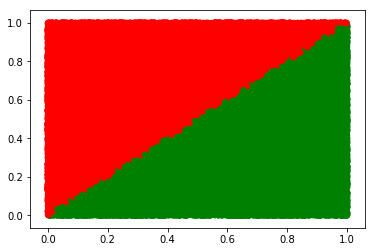

In [422]:
# These are the parameters for the models. Please play with these and note your observations about speed and successful hyperplane formation.
beta = 0.05
N = 300
numsamples = 20000

kernel_file_name = 'k.png'
budget_kernel_file_name = 'bk.png'

# Don't change things below this in your final version. Note that you can use the parameters above to generate multiple graphs if you want to include them in your writeup.
k = KernelPerceptron(numsamples)
k.fit(X,Y)
k.visualize(kernel_file_name, width=0, show_charts=True, save_fig=False, include_points=True)

bk = BudgetKernelPerceptron(beta, N, numsamples)
bk.fit(X, Y)
bk.visualize(budget_kernel_file_name, width=0, show_charts=True, save_fig=False, include_points=True)




In [501]:
speed_conver_dict_kernel = {}

speed_conver_dict_budget = {}

import time

betas = [0,0.1,0.2,0.3,0.4,0.5,1,2,3,4,5]
numsamples = [100,200,300,800,1000,5000,10000,150000,20000]
N = [20,50,100,150,200,300]

for num in tqdm(numsamples):
    print("-"*50)
    print('Random Samples: ',num)
    # Get speed and accuracy of Kernel Perceptron for varios numsamples randomly drawn
    t0 = time.time()
    avg_time = []
    avg_score = []
    for i in range(6):
        
        test_perceptron = KernelPerceptron(num)
        test_perceptron.fit(X,Y)
        # Capture fitting time
        t1 = time.time() - t0
        avg_time.append(t1)
        avg_score.append(test_perceptron.score(X_test,Y_test))
    #Save speed and accuracy of the config (both mean and std)
    speed_conver_dict_kernel[num] = (np.mean(np.array(avg_time)),np.std(np.array(avg_time)),np.std(np.array(avg_score)),np.mean(np.array(avg_score)))
    
    # now look at BudgetKernelPeceptron
    for beta in betas:
        
        print('looping through beta =',beta,'...')
        for number in N:
            avg_time1 = []
            avg_score1 = []
            for i in range(6):
                t0_prime = time.time()
                budget_perceptron_test = BudgetKernelPerceptron(beta=beta,N=number,numsamples=num)
                budget_perceptron_test.fit(X,Y)
                t1_prime = time.time() - t0_prime
                avg_time1.append(avg_score1)

                # gather averages for the accuracy
                avg_score1.append(budget_perceptron_test.score(X_test,Y_test))
            speed_conver_dict_budget[num,beta,number] = (np.mean(np.array(avg_time1)),np.std(np.array(avg_time1)),np.std(np.array(avg_score1)),np.mean(np.array(avg_score1)))
        
    


  0%|          | 0/9 [00:00<?, ?it/s]

--------------------------------------------------
Random Samples:  100
looping through beta = 0 ...



Exception in thread Thread-6:
Traceback (most recent call last):
  File "/Users/filipmichalsky/anaconda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/filipmichalsky/anaconda/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/filipmichalsky/anaconda/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



looping through beta = 0.1 ...
looping through beta = 0.2 ...
looping through beta = 0.3 ...
looping through beta = 0.4 ...
looping through beta = 0.5 ...
looping through beta = 1 ...
looping through beta = 2 ...
looping through beta = 3 ...
looping through beta = 4 ...
looping through beta = 5 ...


 11%|█         | 1/9 [04:34<36:38, 274.76s/it]

--------------------------------------------------
Random Samples:  200
looping through beta = 0 ...
looping through beta = 0.1 ...
looping through beta = 0.2 ...
looping through beta = 0.3 ...
looping through beta = 0.4 ...
looping through beta = 0.5 ...
looping through beta = 1 ...
looping through beta = 2 ...
looping through beta = 3 ...
looping through beta = 4 ...
looping through beta = 5 ...


 22%|██▏       | 2/9 [12:10<42:35, 365.05s/it]

--------------------------------------------------
Random Samples:  300
looping through beta = 0 ...
looping through beta = 0.1 ...
looping through beta = 0.2 ...
looping through beta = 0.3 ...
looping through beta = 0.4 ...
looping through beta = 0.5 ...
looping through beta = 1 ...
looping through beta = 2 ...
looping through beta = 3 ...
looping through beta = 4 ...
looping through beta = 5 ...


 33%|███▎      | 3/9 [23:04<46:09, 461.60s/it]

--------------------------------------------------
Random Samples:  800
looping through beta = 0 ...
looping through beta = 0.1 ...
looping through beta = 0.2 ...
looping through beta = 0.3 ...
looping through beta = 0.4 ...
looping through beta = 0.5 ...
looping through beta = 1 ...
looping through beta = 2 ...
looping through beta = 3 ...
looping through beta = 4 ...
looping through beta = 5 ...


 44%|████▍     | 4/9 [49:04<1:01:20, 736.02s/it]

--------------------------------------------------
Random Samples:  1000
looping through beta = 0 ...
looping through beta = 0.1 ...
looping through beta = 0.2 ...
looping through beta = 0.3 ...
looping through beta = 0.4 ...
looping through beta = 0.5 ...
looping through beta = 1 ...
looping through beta = 2 ...
looping through beta = 3 ...
looping through beta = 4 ...
looping through beta = 5 ...


 56%|█████▌    | 5/9 [1:20:46<1:04:37, 969.38s/it]

--------------------------------------------------
Random Samples:  5000
looping through beta = 0 ...
looping through beta = 0.1 ...
looping through beta = 0.2 ...
looping through beta = 0.3 ...
looping through beta = 0.4 ...
looping through beta = 0.5 ...
looping through beta = 1 ...
looping through beta = 2 ...
looping through beta = 3 ...
looping through beta = 4 ...
looping through beta = 5 ...


 67%|██████▋   | 6/9 [3:52:36<1:56:18, 2326.15s/it]

--------------------------------------------------
Random Samples:  10000
looping through beta = 0 ...
looping through beta = 0.1 ...
looping through beta = 0.2 ...
looping through beta = 0.3 ...
looping through beta = 0.4 ...
looping through beta = 0.5 ...
looping through beta = 1 ...
looping through beta = 2 ...
looping through beta = 3 ...
looping through beta = 4 ...
looping through beta = 5 ...


 78%|███████▊  | 7/9 [8:41:47<2:29:04, 4472.49s/it]

--------------------------------------------------
Random Samples:  150000
looping through beta = 0 ...
looping through beta = 0.1 ...
looping through beta = 0.2 ...
looping through beta = 0.3 ...


KeyboardInterrupt: 

In [456]:
len(betas)*len(numsamples)*len(N)

264

In [462]:
10*250/60

41.666666666666664

In [502]:
speed_conver_dict_kernel1 =speed_conver_dict_kernel
speed_conver_dict_budget1 = speed_conver_dict_budget

In [504]:
len(speed_conver_dict_kernel1)

8

In [506]:
speed_conver_dict_budget1

{(100, 0, 20): (0.8984225947124558,
  0.13010175854090414,
  0.13010175854090414,
  0.8984225947124557),
 (100, 0, 50): (0.9153038975197602,
  0.11571301434709692,
  0.11571301434709691,
  0.91530389751976),
 (100, 0, 100): (0.8910636413191604,
  0.12813390818302572,
  0.12813390818302572,
  0.8910636413191605),
 (100, 0, 150): (0.8858340147179068,
  0.10317290895434575,
  0.10317290895434576,
  0.8858340147179068),
 (100, 0, 200): (0.9620639138729898,
  0.04326732017469196,
  0.04326732017469196,
  0.96206391387299),
 (100, 0, 300): (0.8802125919869175,
  0.12131927476158896,
  0.12131927476158898,
  0.8802125919869175),
 (100, 0.1, 20): (0.9054749250476968,
  0.056948040568775504,
  0.056948040568775504,
  0.905474925047697),
 (100, 0.1, 50): (0.9277050967566096,
  0.07308777857952725,
  0.07308777857952725,
  0.9277050967566094),
 (100, 0.1, 100): (0.925115835377487,
  0.04612476587748557,
  0.04612476587748557,
  0.9251158353774871),
 (100, 0.1, 150): (0.9102275824475333,
  0.06783

In [521]:
list(speed_conver_dict_kernel1.items())

[(100,
  (0.5261901617050171,
   0.3651759325051833,
   0.08796622063528053,
   0.9132938130280729)),
 (200,
  (0.7578337987263998,
   0.5175872809212148,
   0.07391574930509416,
   0.9503611338239303)),
 (300,
  (0.7862780491511027,
   0.5912561698872512,
   0.06171232644487338,
   0.9322192695557373)),
 (800,
  (2.0767268339792886,
   1.3732459968160684,
   0.018241749627418855,
   0.9776335513763968)),
 (1000,
  (1.6997169256210327,
   1.1791856876055031,
   0.02576181170641247,
   0.9811937857726901)),
 (5000,
  (4.376833438873291,
   3.1312492329152852,
   0.00011427166687958515,
   0.999948896156991)),
 (10000,
  (8.800512393315634,
   5.475763960439531,
   0.016577445673723656,
   0.9897962660125375)),
 (150000, (121.43854935963948, 73.79057877396926, 0.0, 1.0))]

[0.3651759325051833, 0.5175872809212148, 0.5912561698872512, 1.3732459968160684, 1.1791856876055031, 3.1312492329152852, 5.475763960439531, 73.79057877396926]
[0.5261901617050171, 0.7578337987263998, 0.7862780491511027, 2.0767268339792886, 1.6997169256210327, 4.376833438873291, 8.800512393315634, 121.43854935963948]


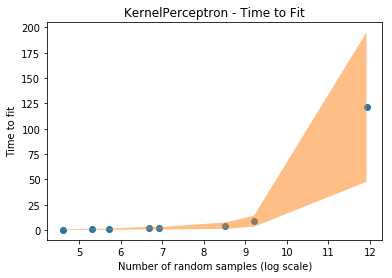

In [550]:
plt.figure()
mean_times = [i[0] for i in speed_conver_dict_kernel1.values()]
stds =  [i[1] for i in speed_conver_dict_kernel1.values()]
print(stds)
print(mean_times)
plt.scatter(np.log(list(speed_conver_dict_kernel1.keys())),mean_times)
plt.xlabel('Number of random samples (log scale)')
plt.ylabel('Time to fit');
plt.title('KernelPerceptron - Time to Fit')
plt.fill_between(np.log(list(speed_conver_dict_kernel1.keys())),np.array(mean_times)-np.array(stds),np.array(mean_times)+np.array(stds),alpha=0.5);

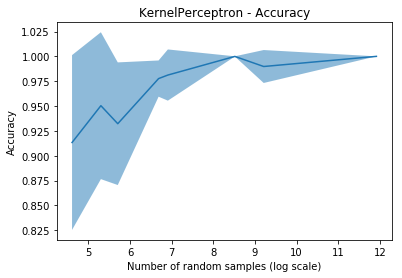

In [554]:
plt.figure()
mean_acc = [i[3] for i in speed_conver_dict_kernel1.values()]
stds =  [i[2] for i in speed_conver_dict_kernel1.values()]
plt.plot(np.log(list(speed_conver_dict_kernel1.keys())),mean_acc)
plt.xlabel('Number of random samples (log scale)')
plt.ylabel('Accuracy');
plt.title('KernelPerceptron - Accuracy');
plt.fill_between(np.log(list(speed_conver_dict_kernel1.keys())),np.array(mean_acc)-np.array(stds),np.array(mean_acc)+np.array(stds),alpha=0.5);

In [560]:
for i in list(speed_conver_dict_budget1.keys()):
    print(i)

(100, 0, 20)
(100, 0, 50)
(100, 0, 100)
(100, 0, 150)
(100, 0, 200)
(100, 0, 300)
(100, 0.1, 20)
(100, 0.1, 50)
(100, 0.1, 100)
(100, 0.1, 150)
(100, 0.1, 200)
(100, 0.1, 300)
(100, 0.2, 20)
(100, 0.2, 50)
(100, 0.2, 100)
(100, 0.2, 150)
(100, 0.2, 200)
(100, 0.2, 300)
(100, 0.3, 20)
(100, 0.3, 50)
(100, 0.3, 100)
(100, 0.3, 150)
(100, 0.3, 200)
(100, 0.3, 300)
(100, 0.4, 20)
(100, 0.4, 50)
(100, 0.4, 100)
(100, 0.4, 150)
(100, 0.4, 200)
(100, 0.4, 300)
(100, 0.5, 20)
(100, 0.5, 50)
(100, 0.5, 100)
(100, 0.5, 150)
(100, 0.5, 200)
(100, 0.5, 300)
(100, 1, 20)
(100, 1, 50)
(100, 1, 100)
(100, 1, 150)
(100, 1, 200)
(100, 1, 300)
(100, 2, 20)
(100, 2, 50)
(100, 2, 100)
(100, 2, 150)
(100, 2, 200)
(100, 2, 300)
(100, 3, 20)
(100, 3, 50)
(100, 3, 100)
(100, 3, 150)
(100, 3, 200)
(100, 3, 300)
(100, 4, 20)
(100, 4, 50)
(100, 4, 100)
(100, 4, 150)
(100, 4, 200)
(100, 4, 300)
(100, 5, 20)
(100, 5, 50)
(100, 5, 100)
(100, 5, 150)
(100, 5, 200)
(100, 5, 300)
(200, 0, 20)
(200, 0, 50)
(200, 0, 100

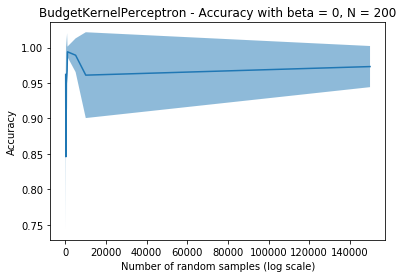

In [573]:
# variation of accuracy with beta = 0, N = 200 across samples
beta = 0
N = 200
mean_acc =[] 
stds =  []
x_axis = []
for key,val in speed_conver_dict_budget1.items():
    if key[1] == beta and key[2] == N:
        x_axis.append(key[0])
        stds.append(speed_conver_dict_budget1[key][1])
        mean_acc.append(speed_conver_dict_budget1[key][0])
plt.figure()

plt.plot(x_axis,mean_acc)
plt.xlabel('Number of random samples (log scale)')
plt.ylabel('Accuracy');
plt.title('BudgetKernelPerceptron - Accuracy with beta = {}, N = {}'.format(beta,N));
plt.fill_between(x_axis,np.array(mean_acc)-np.array(stds),np.array(mean_acc)+np.array(stds),alpha=0.5);

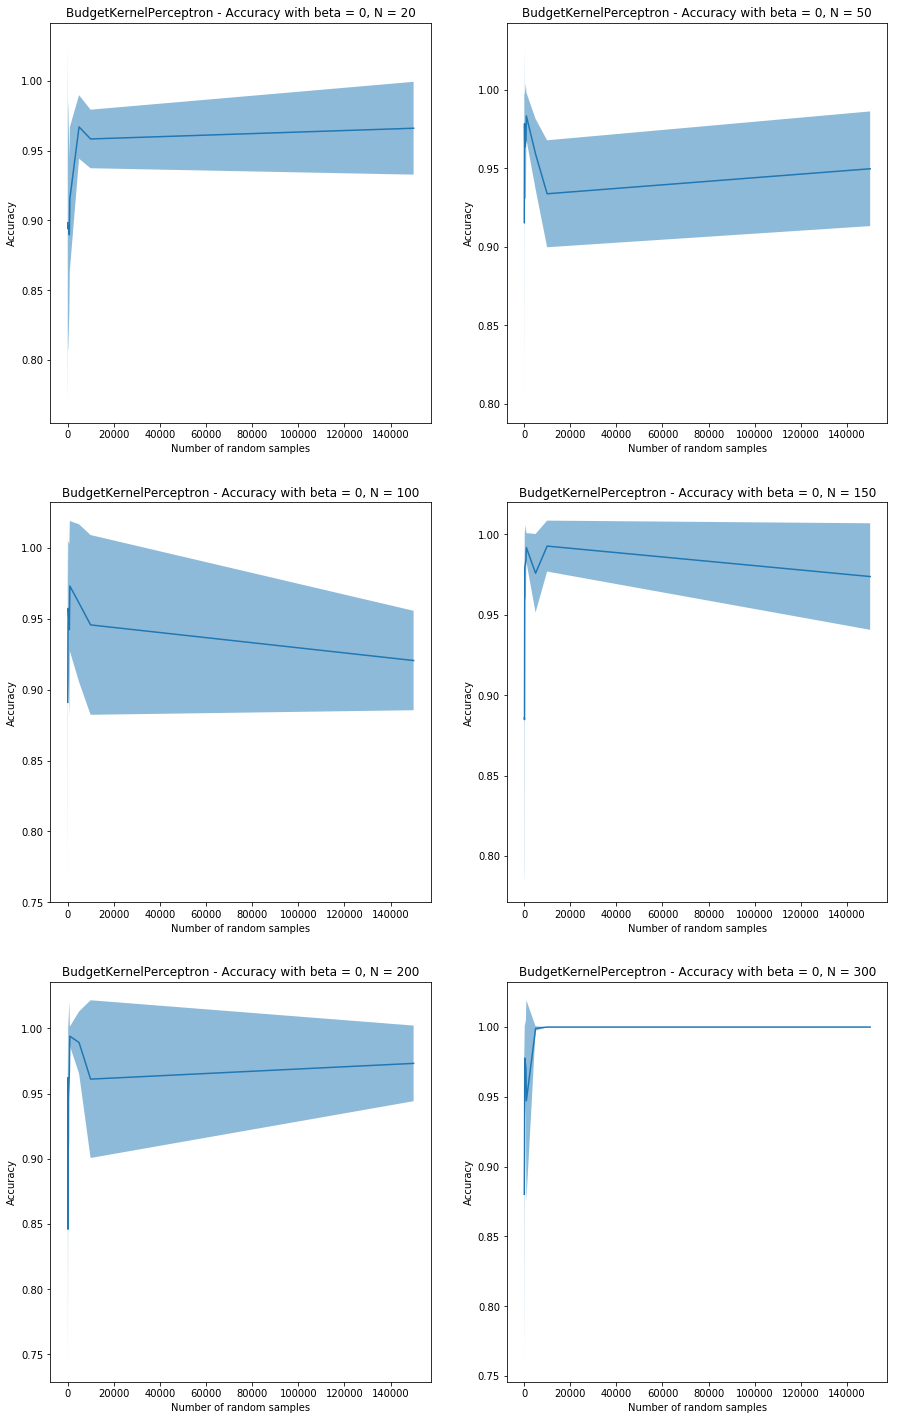

In [609]:
# variation of accuracy with beta = 0, N = 200 across samples
betas = [0,0.1,0.2,0.3,0.4,0.5,1,2,3,4,5]
numsamples = [100,200,300,800,1000,5000,10000,150000,20000]
Ns = [20,50,100,150,200,300]

beta = 0
N = 200
fig, axes = plt.subplots(3, 2,figsize=(15,25));

row,col = (0,0)

for idx,N in enumerate(Ns):
    mean_acc =[] 
    stds =  []
    x_axis = []
    for key,val in speed_conver_dict_budget1.items():
        if key[1] == beta and key[2] == N:
            x_axis.append(key[0])
            stds.append(speed_conver_dict_budget1[key][1])
            mean_acc.append(speed_conver_dict_budget1[key][0])
            
    #axes[row,col].figure(idx,figsize=(5,4))

    axes[row,col].plot(x_axis,mean_acc)
    axes[row,col].set_xlabel('Number of random samples')
    axes[row,col].set_ylabel('Accuracy');
    axes[row,col].set_title('BudgetKernelPerceptron - Accuracy with beta = {}, N = {}'.format(beta,N));
    axes[row,col].fill_between(x_axis,np.array(mean_acc)-np.array(stds),np.array(mean_acc)+np.array(stds),alpha=0.5);
    
    if col % 2 == 0:
        col = 1
    else:
        col=0
        row+=1

8 8
8 8
8 8
7 7
7 7
7 7
7 7
7 7
7 7
7 7
7 7


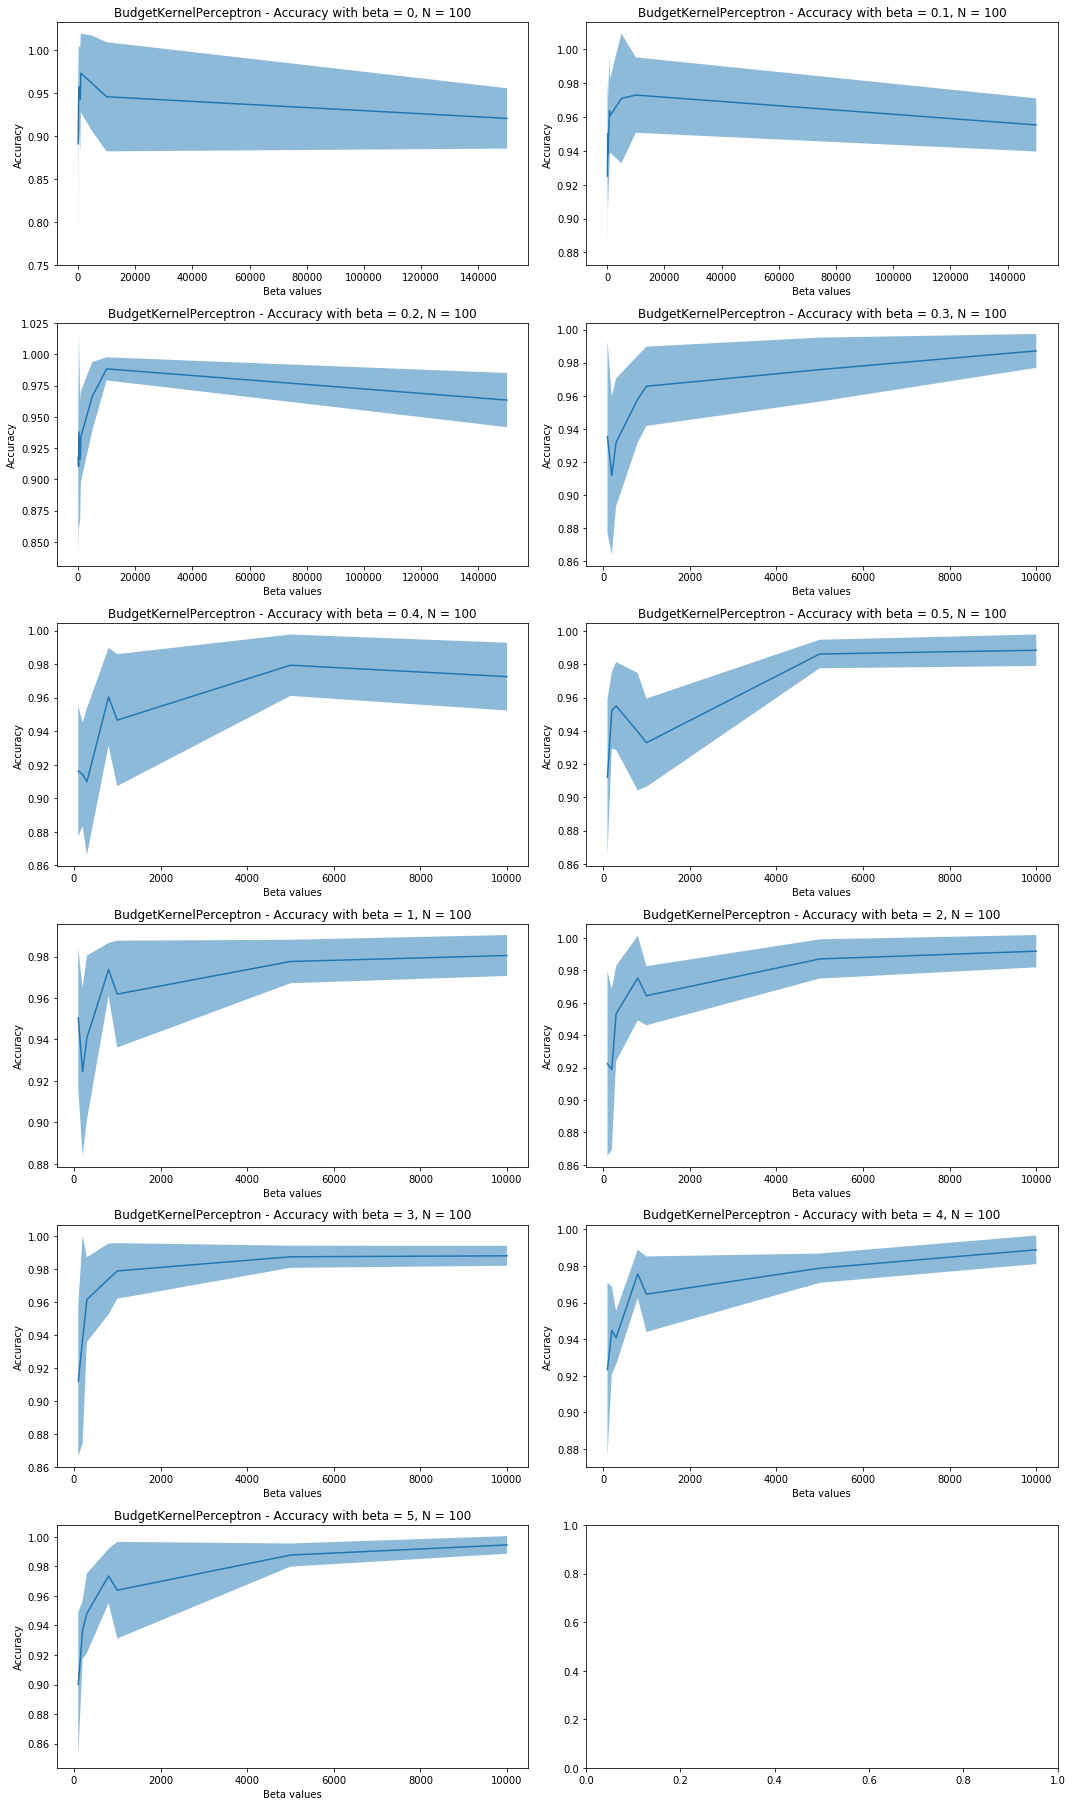

In [641]:
# variation of accuracy with beta = 0, N = 200 across samples
betas = [0,0.1,0.2,0.3,0.4,0.5,1,2,3,4,5]
numsamples = [100,200,300,800,1000,5000,10000,150000,20000]
Ns = [20,50,100,150,200,300]

numsample = 1000

N = 100
fig, axes = plt.subplots(6, 2,figsize=(15,25));

row,col = (0,0)

for idx,beta in enumerate(betas):
    mean_acc =[] 
    stds =  []
    x_axis = []
    for key,val in speed_conver_dict_budget1.items():
        #print(key[0],key[2])
        if key[1] == beta and key[2] == N:
            x_axis.append(key[0])
            stds.append(speed_conver_dict_budget1[key][1])
            mean_acc.append(speed_conver_dict_budget1[key][0])
            
    #print(x_axis)
    #axes[row,col].figure(idx,figsize=(5,4))
    print(len(x_axis),len(mean_acc))
    axes[row,col].plot(x_axis,mean_acc)
    axes[row,col].set_xlabel('Beta values')
    axes[row,col].set_ylabel('Accuracy');
    axes[row,col].set_title('BudgetKernelPerceptron - Accuracy with beta = {}, N = {}'.format(beta,N));
    axes[row,col].fill_between(x_axis,np.array(mean_acc)-np.array(stds),np.array(mean_acc)+np.array(stds),alpha=0.5);
    
    if col % 2 == 0:
        col = 1
    else:
        col=0
        row+=1
        plt.tight_layout()

In [621]:
import json
import sys
f = open(,'w+')
json.dum(speed_conver_dict_budget1,f)
f.close()

FileNotFoundError: [Errno 2] No such file or directory: "['', '/Users/filipmichalsky/anaconda/lib/python36.zip', '/Users/filipmichalsky/anaconda/lib/python3.6', '/Users/filipmichalsky/anaconda/lib/python3.6/lib-dynload', '/Users/filipmichalsky/anaconda/lib/python3.6/site-packages', '/Users/filipmichalsky/anaconda/lib/python3.6/site-packages/aeosa', '/Users/filipmichalsky/anaconda/lib/python3.6/site-packages/xgboost-0.7-py3.6.egg', '/Users/filipmichalsky/anaconda/lib/python3.6/site-packages/pynder-0.0.13-py3.6.egg', '/Users/filipmichalsky/anaconda/lib/python3.6/site-packages/cached_property-1.4.0-py3.6.egg', '/Users/filipmichalsky/anaconda/lib/python3.6/site-packages/IPython/extensions', '/Users/filipmichalsky/.ipython']"

In [669]:
max_k,max_val = 0,0
for key,val in speed_conver_dict_budget1.items():
    if val[-1]>max_val:
        max_val=val[-1]
        max_k =key
print(max_k,max_val)

(150000, 0, 300) 1.0
